#   Bibliotecas utilizadas

In [99]:
import numpy as np
from numpy import random as rnd
import copy
from matplotlib import pyplot as plt
from scipy import optimize as opt
import os


# Constantes

In [100]:
njobs = 25
nmachines = 3
maxtime = 100
nvariables = njobs + nmachines - 1
files = {
    'problemData': './dataset/problemdata.npz',
    'multiObjective': './dataset/multi-objective.npz',
    'makespanOptimization': './dataset/makespan-optimization.npz',
    'sumOptimization': './dataset/sum-optimization.npz',
    'solutionsGraph1': './dataset/solutions-graph1.npz',
    'solutionsGraph2': './dataset/solutions-graph2.npz',
    'solucoesEncontradas': './dataset/solucoes_encontradas.npz'
}

# Geração aletória dos parâmetros do problema

In [101]:
fileExists = os.path.exists(files['problemData'])
if(not fileExists):
    # load variables
    processing = np.round(maxtime*rnd.rand(njobs, nmachines))
    setup = np.round(maxtime*rnd.rand(njobs, njobs, nmachines))
    duedate = np.round(5*maxtime*rnd.rand(njobs))

    
    np.savez_compressed(files['problemData'],
                    njobs=njobs,
                    nmachines=nmachines,
                    maxtime=maxtime,
                    nvariables=nvariables,
                    processing=processing,
                    setup=setup,
                    duedate=duedate)


# Carrega os parâmetros do problema

In [102]:
problemData = np.load(files['problemData'])
processing = problemData['processing']
setup = problemData['setup']
duedate = problemData['duedate']

In [103]:
# Definição da classe que vai carregar os dados do problema\n",
class ProblemData:
   def __init__(self, filename):
     data = np.load(filename)
     self.njobs = int(data['njobs'])
     self.nmachines = int(data['nmachines'])
     self.processing = data['processing']
     self.setup = data['setup']
     self.duedate = data['duedate']
     self.n = int(data['nvariables'])
    
# Carrega os dados a partir do arquivo gerado pelo script gendata.py\n",
probdata = ProblemData(files['problemData'])




*   Classe com as variáveis de decisão do problema



In [104]:
class Solution:
    maxId=0
    def __init__(self):
      # A solução do problema vai estar representada por um vetor\n",
      # no qual é composto pelos índices das tarefas e por -1,\n",
      # sendo que os valores -1 significam separação entre as tarefas\n",
      # de uma máquina para outra. Por exemplo, sejam 10 tarefas\n",
      # e 3 máquinas. Um vetor solução pode ser: [3, 1, 2, -1, \n",
      # 6, 5, 4, 7, -1, 8, 10, 9]. Assim, a máquina 1 realizará\n",
      # a sequência 3-1-2, a máquina 2 realizará 6-5-4-7 e a \n",
      # máquina 3 realizará 8-10-9\n",
      self.solution = None
      
      # Aqui ficará salvo a avaliação da solução na função objetivo\n",
      # considerada.\n",
      self.single_objective_value = None

      self.id = self.maxId+1
      self.maxId += 1
           
    
    # Gerando uma solução aleatoriamente\n",
x0 = Solution() # Cria o objeto\n",
x0.solution = np.zeros(probdata.n, dtype=int) # Enche de zeros\n",
for i in range(probdata.n):
  x0.solution[i] = -1
x0.solution[:probdata.njobs] = np.arange(probdata.njobs, dtype=int) # Coloca os índices nas primeiras posições\n",
x0.solution = rnd.permutation(x0.solution) # Mistura aleatoriamente os elementos do vetor\n",





*   Retorna valor da Soma dos Avanços e Atrasos 




In [105]:
def sum_earliness_tardiness(x,approachinfo,probdata):
    
    N = probdata.njobs # número de tarefas
    M = probdata.nmachines # número de máquinas
    y = np.copy(x.solution)
    
    indexes = np.where(y == -1)[0]
    scheduling = [y[0:indexes[0]]]
    for i in range(indexes.size-1):
          scheduling.append(y[indexes[i]+1:indexes[i+1]])
    scheduling.append(y[indexes[-1]+1:])
    C = np.zeros(N)
    for m in range(M):
        time = 0.
        last_job = -1
        for n in range(scheduling[m].size):
            time += probdata.processing[scheduling[m][n], m]
            if last_job == -1:
                last_job = scheduling[m][n]
            else:
                time += probdata.setup[last_job, scheduling[m][n], m]
                last_job = scheduling[m][n]
            C[scheduling[m][n]] = time
                   
    T = np.zeros(N)
    E = np.zeros(N)
    for n in range(N):
        T[n] = max([C[n]-probdata.duedate[n], 0.])
        E[n] = max([probdata.duedate[n]-C[n], 0.])
    
    x.single_objective_value = np.sum(T) + np.sum(E)
    return x

*   Retorna valor do Makespan

In [106]:
def makespan(x,approachinfo,probdata):
    
    N = probdata.njobs # número de tarefas
    M = probdata.nmachines # número de máquinas
    y = np.copy(x.solution)
    
    indexes = np.where(y == -1)[0]
    scheduling = [y[0:indexes[0]]]
    for i in range(indexes.size-1):
          scheduling.append(y[indexes[i]+1:indexes[i+1]])
    scheduling.append(y[indexes[-1]+1:])
    makespan = np.zeros(M)
    for m in range(M):
        time = 0.
        last_job = -1
        for n in range(scheduling[m].size):
            time += probdata.processing[scheduling[m][n], m]
            if last_job == -1:
                last_job = scheduling[m][n]
            else:
                time += probdata.setup[last_job, scheduling[m][n], m]
                last_job = scheduling[m][n]
        makespan[m] = time
    
    x.single_objective_value = max(makespan)
    return x

# Metaheuristica para resolver o problema mono-objetivo (Algoritmo VNS)

In [107]:
def rvns_approach(fobj,x,probdata,approachinfo,op,maxeval=1000):
    
    # lista de soluções
    solutions = []
    solutions_graph = []
    # Contador do número de soluções candidatas avaliadas
    num_sol_avaliadas = 0

    # Máximo número de soluções candidatas avaliadas
    max_num_sol_avaliadas = maxeval

    # Número de estruturas de vizinhanças definidas
    kmax = 3
       
    # Avalia solução inicial
    x = fobj(x,approachinfo,probdata)
    num_sol_avaliadas += 1
    
    
    # Ciclo iterativo do método
    while num_sol_avaliadas < max_num_sol_avaliadas:
        
        k = 1
        while k <= kmax:

            # Gera uma solução candidata na k-ésima vizinhança de x          
            y = shake(x,k,probdata)
            y = fobj(y,approachinfo,probdata)
            num_sol_avaliadas += 1
            solutions.append(y)
            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k = neighborhoodChange(x, y, k, op,solutions_graph )
    
    return x, solutions, solutions_graph

In [108]:
def neighborhoodChange(x,y,k,op,solutions_graph ):
    
    # op = 1 minimização, op = 2 maximização

    if op == 1:
      if y.single_objective_value < x.single_objective_value:
          x = copy.deepcopy(y)
          k = 1
          solutions_graph.append(x.single_objective_value) 
      else:
          solutions_graph.append(x.single_objective_value) 
          k += 1

    if op == 2:
      if y.single_objective_value > x.single_objective_value:
          x = copy.deepcopy(y)
          k = 1
      else:
          k += 1
        
    return x, k

In [109]:
def shake(x,k,probdata):
    
    y = copy.deepcopy(x)
    r = np.random.permutation(probdata.n)       
    
    if k == 1:             # exchange one pair of elements
        aux = y.solution[r[0]]
        y.solution[r[0]] = y.solution[r[1]]
        y.solution[r[1]] = aux
        
    elif k == 2:           # exchange two pairs of elements      
        aux = y.solution[r[0]]
        y.solution[r[0]] = y.solution[r[1]]
        y.solution[r[1]] = aux
        aux = y.solution[r[2]]
        y.solution[r[2]] = y.solution[r[3]]
        y.solution[r[3]] = aux
        
    elif k == 3:           # exchange three pairs of elements   
        aux = y.solution[r[0]]
        y.solution[r[0]] = y.solution[r[1]]
        y.solution[r[1]] = aux
        aux = y.solution[r[2]]
        y.solution[r[2]] = y.solution[r[3]]
        y.solution[r[3]] = aux
        aux = y.solution[r[4]]
        y.solution[r[4]] = y.solution[r[5]]
        y.solution[r[5]] = aux   
    
    return y



# Problema Mono-Objetivo: Soma de atrasos e adiantamentos

In [110]:
maxeval = 100000
def optimizeSumExec():
  # Encontra melhor solução para Soma Avanços Atrasos ,
  bestf1, _, solutions_graph1 = rvns_approach(sum_earliness_tardiness,
                                  x0,
                                  probdata,
                                  None,
                                  1,
                                  maxeval=maxeval)

  bestf1.solution=np.insert(bestf1.solution,0,bestf1.single_objective_value)
  np.savez_compressed(files['sumOptimization'], f1Solution=bestf1.solution)
  np.savez_compressed(files['solutionsGraph1'], solutionsGraph1=solutions_graph1)
  
    

fileExists = os.path.exists(files['sumOptimization'])
if(not fileExists):
  optimizeSumExec()

f1Solution = np.load(files['sumOptimization'])['f1Solution']
bestf1 = Solution()
bestf1.single_objective_value = f1Solution[0]
bestf1.solution = f1Solution[1:]

solutions_graph1 = np.load(files['solutionsGraph1'])['solutionsGraph1']

# Mostra informações
print("Soma dos Avanços e Atrasos")
print("Solução utópica: ", bestf1.solution)                                
print("Soma dos Avanços e Atrasos utópico: ",bestf1.single_objective_value)


Soma dos Avanços e Atrasos
Solução utópica:  [17 16  0 12 18  8 20  5  3 23 21 -1  2 14  7 15  1  4 19 13 -1 11  6 10
 22 24  9]
Soma dos Avanços e Atrasos utópico:  1366


# Problema Mono-Objetivo: Makespan

In [111]:
# Encontra melhor solução makespan ,
def optimizeMakespanExec():
  bestf2, _, solutionsGraph2  = rvns_approach(makespan,
                                  x0,
                                  probdata,
                                  None,1,
                                  maxeval=maxeval)
  bestf2.solution=np.insert(bestf2.solution,0,bestf2.single_objective_value)
  np.savez_compressed(files['makespanOptimization'], f2Solution=bestf2.solution)
  np.savez_compressed(files['solutionsGraph2'], solutionsGraph2=solutionsGraph2)

fileExists = os.path.exists(files['makespanOptimization'])
if(not fileExists):
  optimizeMakespanExec()

f2Solution = np.load(files['makespanOptimization'])['f2Solution']
bestf2 = Solution()
bestf2.single_objective_value = f2Solution[0]
bestf2.solution = f2Solution[1:]

solutions_graph2 = np.load(files['solutionsGraph2'])['solutionsGraph2']

print(" Makespan ")
print("Solução utópica: ", bestf2.solution)                                
print("Makespan utópico: ",bestf2.single_objective_value)

 Makespan 
Solução utópica:  [20 16 18 17 15 22  8 12 23 -1 14  5 11  3  4 19  0  1 10 24  7 -1 13  2
  6 21  9]
Makespan utópico:  424


# Gráficos de convergência

## Soma de Atrasos e Adiantamentos

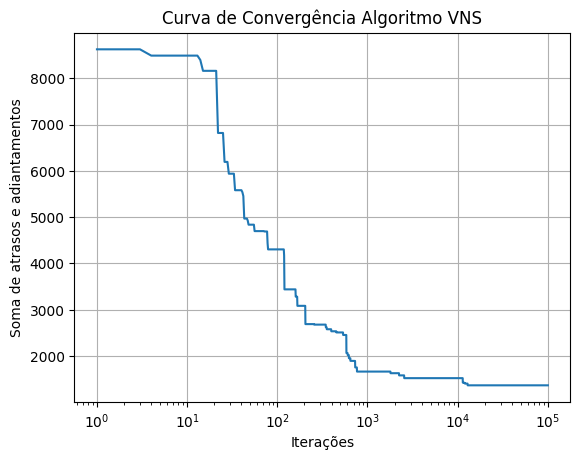

In [112]:
plt.title("Curva de Convergência Algoritmo VNS")
plt.ylabel('Soma de atrasos e adiantamentos')
plt.xlabel('Iterações')
plt.semilogx(np.arange(1,len(solutions_graph1)+1), solutions_graph1)
plt.grid()
plt.show()

## Makespan

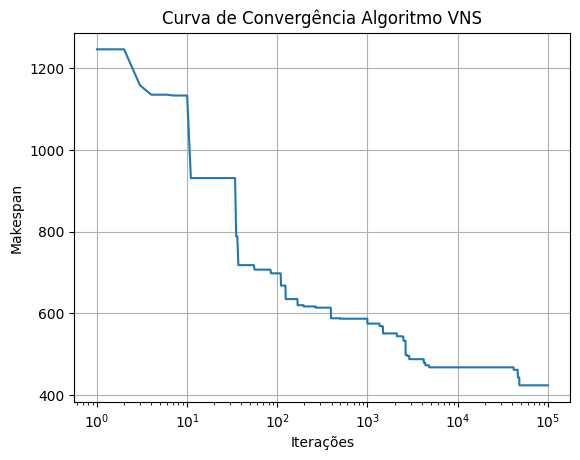

In [113]:
plt.title("Curva de Convergência Algoritmo VNS")
plt.ylabel('Makespan')
plt.xlabel('Iterações')
plt.semilogx(np.arange(1,len(solutions_graph2)+1), solutions_graph2)
plt.grid()
plt.show()

## Ponto utópico e ponto anti-utópico

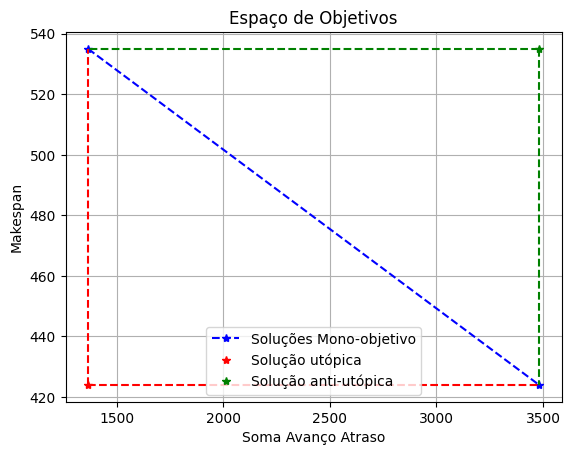

In [114]:
bestf1.f1 = bestf1.single_objective_value # Soma de atrasos e adiantamentos da melhor solução deste objetivo
y = makespan(bestf1, None, probdata)
bestf1.f2 = y.single_objective_value # Makespan da melhor solução para o objetivo de soma de atrasos e adiantamentos

bestf2.f2 = bestf2.single_objective_value # Makespan da melhor solução deste objetivo
y = sum_earliness_tardiness(bestf2, None, probdata)
bestf2.f1 = y.single_objective_value # Soma de atrasos e adiantamentos da melhor solução para o makespan

ponto_utopico = np.array([bestf1.f1, bestf2.f2]) # O ponto utópico é o melhor valor dos dois objetivos encontrados
ponto_antiutopico = np.array([bestf2.f1, bestf1.f2]) # O ponto anti-utópico é o valor da soma encontrada pela minimização do makespam e vice-versa

# Plota soluções do problema mono-objetivo e soluções utópicas e anti-utópicas
plt.plot([bestf1.f1, bestf2.f1], [bestf1.f2, bestf2.f2], '--*b', label='Soluções Mono-objetivo')
plt.plot(ponto_utopico[0], ponto_utopico[1], '*r', label='Solução utópica')
plt.plot(ponto_antiutopico[0], ponto_antiutopico[1], '*g', label='Solução anti-utópica')

# Algumas linhas só pra ajudar na visualização
plt.plot([ponto_utopico[0], bestf2.f1], [ponto_utopico[1], bestf2.f2], '--r')
plt.plot([ponto_utopico[0], bestf1.f1], [ponto_utopico[1], bestf1.f2], '--r')
plt.plot([ponto_antiutopico[0], bestf2.f1], [ponto_antiutopico[1], bestf2.f2], '--g')
plt.plot([ponto_antiutopico[0], bestf1.f1], [ponto_antiutopico[1], bestf1.f2], '--g')

plt.title('Espaço de Objetivos')
plt.ylabel('Makespan')
plt.xlabel('Soma Avanço Atraso')
plt.legend()
plt.grid()
plt.show()




# Função objetivo que implementa o método do $\epsilon$-restrito

In [115]:
def epsilon_constraint(x,approachinfo,probdata):
    
    N = probdata.njobs # número de tarefas
    M = probdata.nmachines # número de máquinas
    y = np.copy(x.solution)
    
    indexes = np.where(y == -1)[0]
    scheduling = [y[0:indexes[0]]]
    for i in range(indexes.size-1):
          scheduling.append(y[indexes[i]+1:indexes[i+1]])
    scheduling.append(y[indexes[-1]+1:])
    C = np.zeros(N)
    for m in range(M):
        time = 0.
        last_job = -1
        for n in range(scheduling[m].size):
            time += probdata.processing[scheduling[m][n], m]
            if last_job == -1:
                last_job = scheduling[m][n]
            else:
                time += probdata.setup[last_job, scheduling[m][n], m]
                last_job = scheduling[m][n]
            C[scheduling[m][n]] = time
                   
    T = np.zeros(N)
    E = np.zeros(N)
    for n in range(N):
        T[n] = max([C[n]-probdata.duedate[n], 0.])
        E[n] = max([probdata.duedate[n]-C[n], 0.])
    
    # Implementação do método do epsilon-restrito:
    #    Penaliza soluções cujo a makespan ultrapassa o valor
    #    de epsilon.
    makespan = np.amax(C)
    if makespan > approachinfo.epsilon:
        penalizacao = approachinfo.grau_penalizacao*(makespan - approachinfo.epsilon)**2
    else:
        penalizacao = 0.
    
    x.single_objective_value = np.sum(T) + np.sum(E) + penalizacao
    x.sum = np.sum(T) + np.sum(E)
    x.makespan = makespan
    return x


# Função para Execução do Método do $\epsilon$-restrito

In [116]:
def epsilon_constraint_exec():
  # Criando uma classe para abrigar a informação de epsilon e penalização
  class ApproachInfo:
    pass
  
  # Intervalo de valores de epsilon: do maior ao menor makespan
  epsilon = np.linspace(bestf1.f2, bestf2.f2, 20)

  approachinfo = ApproachInfo()
  approachinfo.grau_penalizacao = 1e4 # penalização

  # Lista que irá armazenar conjunto de soluções encontradas
  solucoes_encontradas = [bestf1] 

  # Avaliação nos dois objetivos das soluções encontradas:
  # Na primeira coluna, soma. Na segunda, makespan.
  avaliacao_solucoes = np.zeros((epsilon.size, 2))

  # A primeira solução é a melhor f1 encontrada que possui o f2 mais alto.
  avaliacao_solucoes[0, 0] = bestf1.f1
  avaliacao_solucoes[0, 1] = bestf1.f2
  for n in range(1, epsilon.size-1):
      
      # Atualiza o epsilon
      approachinfo.epsilon = epsilon[n]
      
      # Resolve o provlema
      solucao, _, _ = rvns_approach(epsilon_constraint,
                                    bestf1,
                                    probdata,
                                    approachinfo,
                                    1,
                                    maxeval=maxeval)
      
      # Salva informações
      solucoes_encontradas.append(solucao)
      avaliacao_solucoes[n, 0] = solucao.sum
      avaliacao_solucoes[n, 1] = solucao.makespan

    # A última solução é aquela encontrada na otimização mono-objetivo do makespan
  solucoes_encontradas.append(bestf2)
  avaliacao_solucoes[-1, 0] = bestf2.f1
  avaliacao_solucoes[-1, 1] = bestf2.f2
  np.savez_compressed(files['multiObjective'],avaliacao_solucoes=avaliacao_solucoes)
  np.savez_compressed(files['solucoesEncontradas'],solucoes_encontradas=solucoes_encontradas)

# Busca as soluções da otimização multi-objetivo

In [117]:
fileExists = os.path.exists(files['multiObjective'])
if(not fileExists):
  epsilon_constraint_exec()

avaliacao_solucoes = np.load(files['multiObjective'])['avaliacao_solucoes']

# Plota soluções encontradas no espaço de objetivos

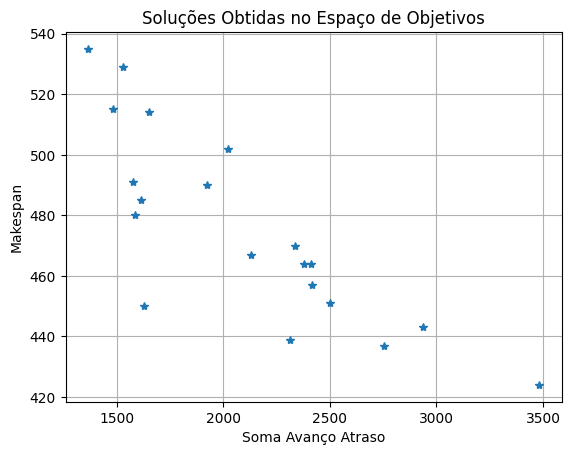

In [118]:
plt.plot(avaliacao_solucoes[:, 0], avaliacao_solucoes[:, 1], '*')
plt.title('Soluções Obtidas no Espaço de Objetivos')
plt.ylabel('Makespan')
plt.xlabel('Soma Avanço Atraso')
plt.grid()
plt.show()

* Note que pode haver soluções que são dominadas. Isso é normal porque seu algoritmo é uma heurística, ou seja, ela não garante otimalidade global. Em outras palavras, isso significa o seguinte: quando você rodou o problema mono-objetivo, a solução que você obteve não é a melhor de todas as possíveis (ótima global). Logo, pode ser que, quando você está resolvendo o problema aplicando o método do $\epsilon$-restrito, pode ser que você encontre uma outra solução que é melhor tanto em um objetivo como em outro.
* Portanto, o próximo passo é obter a fronteira pareto dessas soluções que você encontrou:

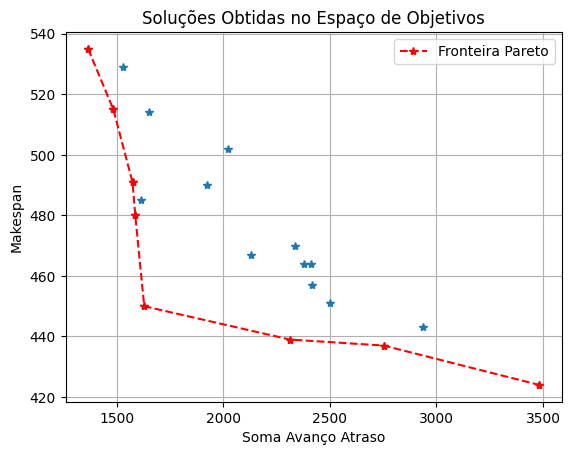

In [119]:
def pareto(sum, makespan):
  
  # Vetor que vai guardar os índices das soluções não dominadas
  nao_dominadas = []
  
  # Número de soluções
  N = len(sum)
  
  for i in range(N):
    FLAG_DOMINADA = False
    
    # Eu vou comparar cada par de solução...
    for j in range(N):
      
      # Exceto uma solução com ela mesma
      if i == j:
        continue
      
      # Se a solução i for dominada por alguma outra, eu ativo a flag de dominância e paro de fazer comparações com i
      elif (sum[i] >= sum[j] and makespan[i] > makespan[j]) or (sum[i] > sum[j] and makespan[i] >= makespan[j]):
        FLAG_DOMINADA = True
        break
    
    # Se a solução i não for dominada por nenhuma outra, eu salvo o índice dela
    if not FLAG_DOMINADA:
      nao_dominadas.append(i)

  return np.array(nao_dominadas)


conjuntoParetoOtimo = {
  'sum': avaliacao_solucoes[:, 0],
  'makespan': avaliacao_solucoes[:, 1]
}


# Determina a fronteira Pareto
nao_dominadas = pareto(conjuntoParetoOtimo['sum'],conjuntoParetoOtimo['makespan']) 


fronteiraParetoOtima = {
  'sum': avaliacao_solucoes[nao_dominadas, 0],
  'makespan': avaliacao_solucoes[nao_dominadas, 1]
}

# Plota a Fronteira com as demais soluções
plt.plot(conjuntoParetoOtimo['sum'],conjuntoParetoOtimo['makespan'], '*')
plt.plot(fronteiraParetoOtima['sum'],fronteiraParetoOtima['makespan'], '*--r', label='Fronteira Pareto')
plt.title('Soluções Obtidas no Espaço de Objetivos')
plt.ylabel('Makespan')
plt.xlabel('Soma Avanço Atraso')
plt.legend()
plt.grid()
plt.show()

# Critérios de Decisão

## Solução com tarefas melhor distribuídas

obs: sugestão de função dada pelo professor. Porém, todas as soluções colocam o mesmo número de tarefas para todas as máquinas, então sempre vai retornar o id 1 (correspondente à primeira máquina)

In [126]:
def getBestDistributedSolution():
    solucoes_encontradas = np.load(files['solucoesEncontradas'], allow_pickle=True)['solucoes_encontradas']

    bestSolution = {
        'task_distribution_index': 9999, # valor inicial apenas
        'data': solucoes_encontradas[0]
    }

    for solucao_encontrada in solucoes_encontradas:
        solution = solucao_encontrada.solution
        tasksPerMachine = []
        tasks = 0
        for i in range(len(solution)):
            if(solution[i] == -1):
                tasksPerMachine.append(tasks)
                tasks = 0
            else:
                tasks += 1
                if(len(solution) == i+1):
                    tasksPerMachine.append(tasks)

        localDistributionIndex = max(tasksPerMachine) - min(tasksPerMachine)
        if localDistributionIndex < bestSolution['task_distribution_index']:
            bestSolution['task_distribution_index'] = localDistributionIndex
            bestSolution['data'] = solucao_encontrada
    return bestSolution

bestDistributedSolution = getBestDistributedSolution()
print(bestDistributedSolution['data'].id)

1
